# Haslam/WMAP Synchrotron templates for PySM 3
> Synchrotron templates based on Haslam for Temperature and WMAP for polarization in logarithmic polarization fraction formalism (logpoltens) with injection of simulated small scale fluctuations

This new implementation of small scale injection will homogeneize the synchrotron models to the latest updates implemented on  dust : 
- input templates the same as before: HASLAM (rescaled to 23GHz and WMAP K-band, smoothed at 2deg)
- two pivot scales `ell1=36`,`ell2=400` for small scale injection
- spectral indices for EE, BB coming from literature , [Planck 2018]( https://arxiv.org/pdf/1807.06208.pdf) : 
 i.  alpha_TT=alpha_TE= -1 
 ii. alpha_EE = -0.84 
 iii. alpha_BB= -0.78
Notice that for TT and TE the value is justified by what actually see in the spectra of input maps, see the plot in cell `[31]`.
- small scales have with non-zero TE 
- Modulation of qu maps with a single map, p:
 i. to avoid modulation w/ negative values,
 ii. to preserve non-zero TE 
- we propose to modulate polarization small scales as it has been done in `pysm2`(https://arxiv.org/pdf/1608.02841.pdf) ,  with a couple of differences: 
 i. small scales are expected to be injected with   non-gaussian content (thanks to the  logpoltens formalism); 
ii. split the sky with  high reso pixels (nside=8) ; 
iii. use amplitude of E-mode spectra to derive the modulation template

## Related notebooks

* [Simplified version of this notebook that generates small scales up to $\ell_{max}=16384$](synchrotron_template_logpoltens_generate_artifacts.ipynb)
* [Notebook that generates small scales for the spectral index $\beta$](synchrotron_beta.ipynb)
* [Notebook that generates the template for curvature for `s7`](synchrotron_curvature.ipynb)
* Notebooks that create maps at different resolutions for [templates](utils_synch_generate_map.ipynb), for [spectral index](utils_synch_generate_map_spectralindex.ipynb) and for [curvature](utils_synch_generate_map_curvature.ipynb)

In [1]:
import os

os.environ[
    "OMP_NUM_THREADS"
] = "64"  # for jupyter.nersc.gov otherwise the notebook only uses 2 cores

output_files = []

from datetime import date
today = date.today()
version = today.strftime("%Y.%m.%d")
version

'2023.02.24'

In [2]:
from pathlib import Path
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np

# import pymaster as nmt
from astropy.io import fits

%matplotlib inline

plt.style.use("seaborn-talk")

/tmp/ipykernel_17579/3930590641.py:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-talk")


In [3]:
hp.disable_warnings()

In [4]:
import pysm3 as pysm
import pysm3.units as u
from pysm3.utils import add_metadata

In [5]:
nside = 512
lmax = 3 * nside

In [6]:
comp = "IQU"

In [7]:
components = list(enumerate(comp))
components

[(0, 'I'), (1, 'Q'), (2, 'U')]

In [8]:
spectra_components = ["TT", "EE", "BB", "TE"]

change this to True   if you want to  run namaster on notebook 


In [9]:
namaster_on_nb = True

In [10]:
datadir = Path("synch_data")

In [11]:
proddir = Path("production-data") / "synch" / "raw"

In [12]:
imapfile = datadir / "haslam408_dsds_Remazeilles2014.fits"
qumapfile = datadir / "wmap_band_iqumap_r9_9yr_K_v5.fits"

In [13]:
if not imapfile.exists():
    !wget -O $imapfile   https://lambda.gsfc.nasa.gov/data/foregrounds/haslam_2014/haslam408_dsds_Remazeilles2014.fits

In [14]:
if not qumapfile.exists():
    !wget -O $qumapfile   https://lambda.gsfc.nasa.gov/data/map/dr5/skymaps/9yr/raw/wmap_band_iqumap_r9_9yr_K_v5.fits

In [15]:
imap = hp.read_map(imapfile)
qumap = hp.read_map(qumapfile, field=[1, 2])


# Setting the inputs 
## Synchrotron   maps 
- We use the Haslam map at 408MHz for the intensity template 
- for Q and U we adopt maps from the K-band of WMAP .  


- rescaling Haslam map to 23 GHz **assuming a constant spectral index =-3.1**   and from K to uK 
- converting Wmap maps to from mK to uK  
- we reduce noise by smoothing to 2 deg 



In [16]:
rescaling_factor = (23.0 / 0.408) ** -3.1

imap *= rescaling_factor
imap <<= u.K_RJ
imap = imap.to(u.uK_RJ)
qumap <<= u.mK_RJ
qumap = qumap.to("uK_RJ")

In [17]:
IQU = np.array([imap, qumap[0], qumap[1]])

In [18]:
FWHM_SMOOTHING = 2  # deg
IQU = hp.smoothing(IQU, fwhm=np.radians(FWHM_SMOOTHING))
IQU <<= u.uK_RJ

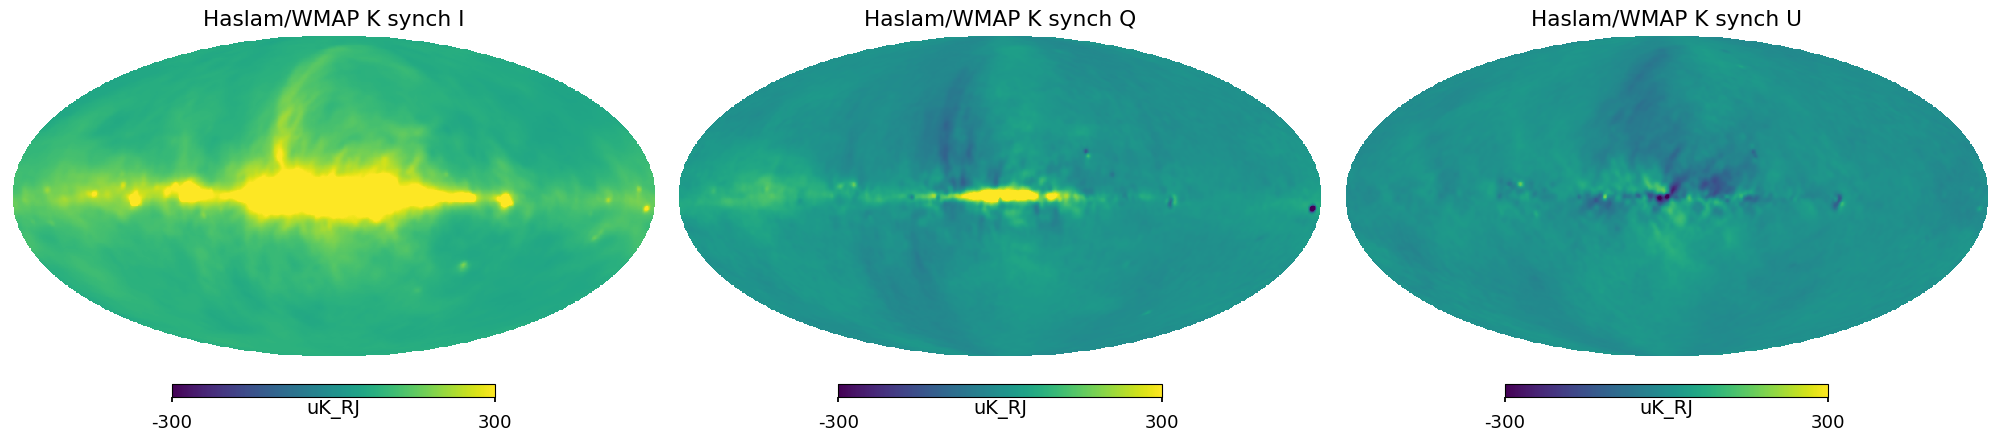

In [19]:
plt.figure(figsize=(20, 5))
for i_pol, pol in components:
    hp.mollview(
        IQU[i_pol],
        title="Haslam/WMAP K synch " + pol,
        sub=131 + i_pol,
        unit=IQU.unit,
        min=-300,
        max=300,
    )

In [20]:
if not os.path.exists(datadir / "synch_hybrid.fits"):
    hp.write_map(datadir / "synch_hybrid.fits", IQU)

In [21]:
import numpy as np
import healpy as hp


def map_to_log_pol_tens(m):
    P = np.sqrt(m[1] ** 2 + m[2] ** 2)
    log_pol_tens = np.empty_like(m)
    log_pol_tens[0] = np.log(m[0] ** 2 - P**2) / 2.0
    log_pol_tens[1:] = m[1:] / P * np.log((m[0] + P) / (m[0] - P)) / 2.0
    return log_pol_tens


def log_pol_tens_to_map(log_pol_tens):
    P = np.sqrt(log_pol_tens[1] ** 2 + log_pol_tens[2] ** 2)
    m = np.empty_like(log_pol_tens)
    exp_i = np.exp(log_pol_tens[0])
    m[0] = exp_i * np.cosh(P)
    m[1:] = log_pol_tens[1:] / P * exp_i * np.sinh(P)
    return m


def sigmoid(x, x0, width, power=4):
    """Sigmoid function given start point and width
    Parameters
    ----------
    x : array
        input x axis
    x0 : float
        value of x where the sigmoid starts (not the center)
    width : float
        width of the transition region in unit of x
    power : float
        tweak the steepness of the curve
    Returns
    -------
    sigmoid : array
        sigmoid, same length of x"""
    return 1.0 / (1 + np.exp(-power * (x - x0 - width / 2) / width))

In [22]:
iqu = map_to_log_pol_tens(IQU.value)

/tmp/ipykernel_17579/1699011499.py:8: RuntimeWarning: invalid value encountered in log
  log_pol_tens[0] = np.log(m[0] ** 2 - P**2) / 2.0
/tmp/ipykernel_17579/1699011499.py:9: RuntimeWarning: invalid value encountered in log
  log_pol_tens[1:] = m[1:] / P * np.log((m[0] + P) / (m[0] - P)) / 2.0


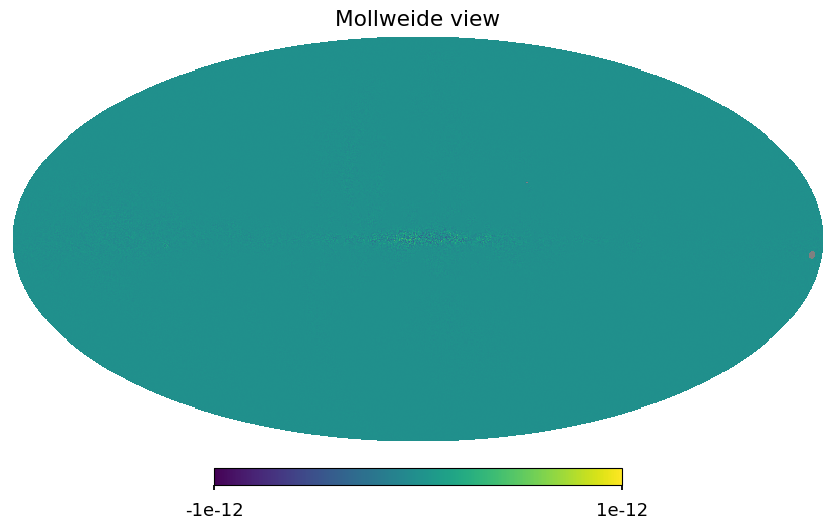

In [23]:
m_back = log_pol_tens_to_map(iqu)
hp.mollview((IQU.value - m_back)[1], min=-1e-12, max=1e-12)
del m_back

In [24]:
print(
    f"{np.isnan(iqu[0]).sum()  } pixels out of { iqu[0].size} are NaNs in Log Pol Tens maps "
)
for i in range(3):
    iqu[i, np.isnan(iqu[i])] = np.nanmedian(iqu[i])
assert np.isnan(iqu).sum() == 0
print(
    f"{np.isnan(iqu[0]).sum()  } pixels out of { iqu[0].size} are NaNs in Log Pol Tens maps "
)

527 pixels out of 3145728 are NaNs in Log Pol Tens maps 
0 pixels out of 3145728 are NaNs in Log Pol Tens maps 


In [25]:
if not os.path.exists(datadir / "synch_logpoltens.fits"):
    hp.write_map(datadir / "synch_logpoltens.fits", iqu)

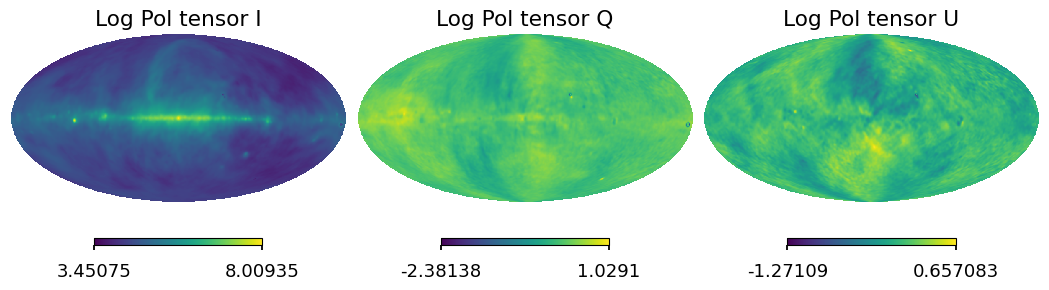

In [26]:
for i_pol, pol in components:
    hp.mollview(iqu[i_pol], title="Log Pol tensor " + pol, sub=131 + i_pol)

In [27]:
from scipy.optimize import curve_fit

In [28]:
def model(ell, A, gamma):
    out = A * ell**gamma
    return out

In [29]:
def run_anafast(m, lmax):
    clanaf = hp.anafast(m, lmax=lmax)
    cl = {}
    cl["TT"] = clanaf[0]
    cl["EE"] = clanaf[1]
    cl["BB"] = clanaf[2]
    cl["TE"] = clanaf[3]
    ell = np.arange(lmax + 1, dtype=float)

    cl_norm = ell * (ell + 1) / np.pi / 2
    cl_norm[0] = 1
    return ell, cl_norm, cl


def run_namaster(m, mask, lmax, nlbins):
    """Compute C_ell with NaMaster
    Parameters
    ----------
    m : numpy array
        T only or TQU HEALPix map
    mask : numpy array
        mask, 1D, 0 for masked pixels,
        needs to have same Nside of the input map
    lmax : int
        maximum ell of the spherical harmonics transform
    Returns
    -------
    ell : numpy array
        array of ell from 0 to lmax (length lmax+1)
    cl_norm : numpy array
        ell (ell+1)/2pi factor to turn C_ell into D_ell
        first element is set to 1
    cl : dict of numpy arrays
        dictionary of numpy arrays with all components
        of the spectra, for now only II, EE, BB, no
        cross-spectra
    """

    nside = hp.npix2nside(len(mask))
    # b = nmt.NmtBin.from_nside_linear(nside, 16)
    # leff = b.get_effective_ells()
    binning = nmt.NmtBin(nside=nside, nlb=nlbins, lmax=lmax, is_Dell=False)

    cl = {}

    if len(m) == 3:
        f_0 = nmt.NmtField(mask, [m[0]])
        f_2 = nmt.NmtField(
            mask, m[1:].copy(), purify_b=True
        )  # NaMaster masks the map in-place
        cl_namaster = nmt.compute_full_master(f_2, f_2, binning)
        cl["EE"] = np.concatenate([[0, 0], cl_namaster[0]])
        cl["BB"] = np.concatenate([[0, 0], cl_namaster[3]])
        cl_namaster = nmt.compute_full_master(f_0, f_2, binning)
        cl["TE"] = np.concatenate([[0, 0], cl_namaster[0]])
    elif m.ndim == 1:
        m = m.reshape((1, -1))
        f_0 = nmt.NmtField(mask, [m[0]])

    cl_namaster_I = nmt.compute_full_master(f_0, f_0, binning)

    cl["TT"] = np.concatenate([[0, 0], cl_namaster_I[0]])
    ell = np.concatenate([[0, 1], binning.get_effective_ells()])
    cl_norm = ell * (ell + 1) / np.pi / 2
    cl_norm[0] = 1
    return ell, cl_norm, cl

In [30]:
ell, cl_norm, cl = run_anafast(iqu, lmax)

## Power law fit 

- We fit in$\ell \in[1-,36]$ a power law for TT spectrum of the logpol tens i map
- we use the spectral index power law also for EE and BB power spectra to avoid unphysical crossings of EE over TT and BB over TT at higher multipoles


/tmp/ipykernel_17579/3875259470.py:2: RuntimeWarning: divide by zero encountered in reciprocal
  out = A * ell**gamma
/tmp/ipykernel_17579/3875259470.py:2: RuntimeWarning: divide by zero encountered in power
  out = A * ell**gamma


(1e-05, 0.1)

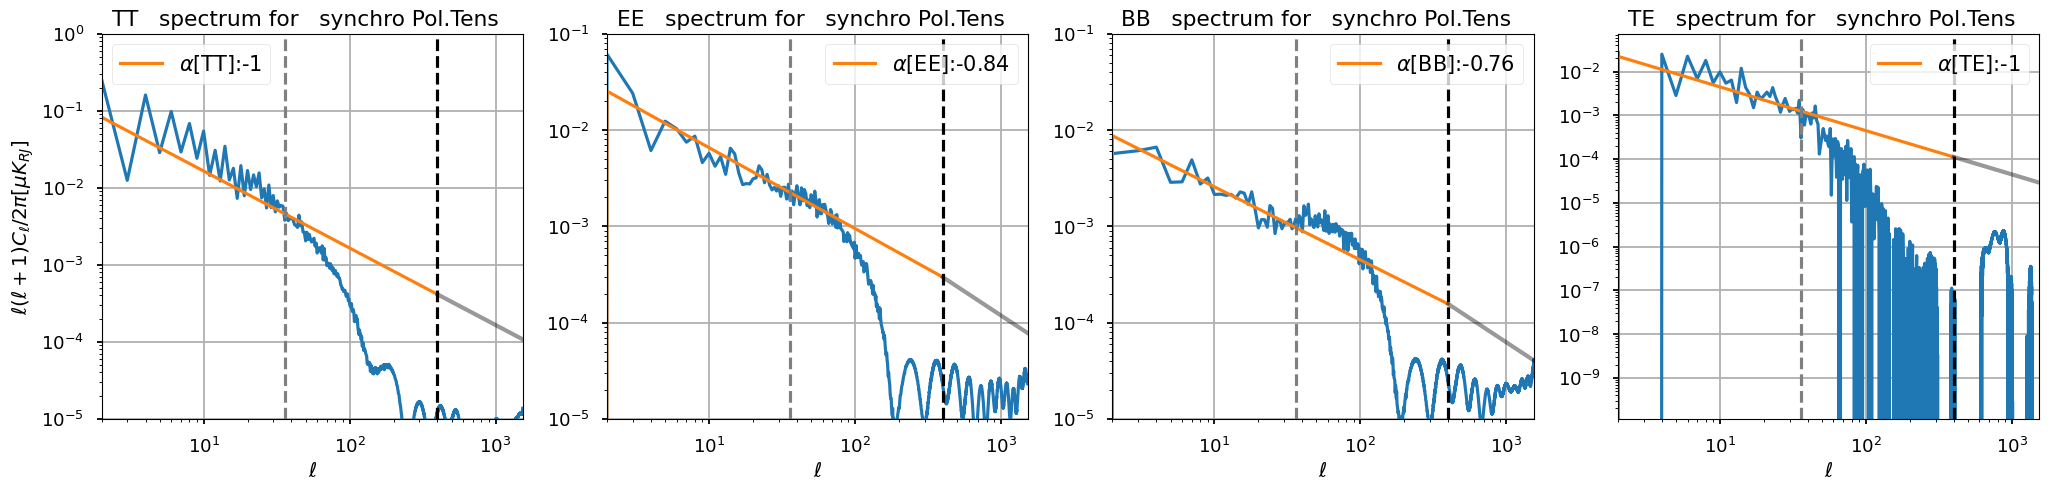

In [31]:
ell_fit_low = {"TT": 10, "EE": 10, "BB": 10, "TE": 10}
ell_fit_high = {"TT": 36, "EE": 36, "BB": 36, "TE": 36}
gamma_fit2 = {"TT": -1, "EE": -0.84, "BB": -0.76, "TE": -1}
A_fit, gamma_fit, A_fit_std, gamma_fit_std = {}, {}, {}, {}
plt.figure(figsize=(25, 5))
A_fit2 = {}
smallscales = []

ell_pivot = 400
for ii, pol in enumerate(spectra_components):
    plt.subplot(141 + ii)
    xdata = np.arange(ell_fit_low[pol], ell_fit_high[pol])
    ydata = xdata * (xdata + 1) / np.pi / 2 * cl[pol][xdata]
    (A_fit[pol], gamma_fit[pol]), cov = curve_fit(model, xdata, ydata)
    A_fit2[pol] = np.fabs(A_fit[pol]) * ell_fit_high[pol] ** (
        gamma_fit[pol] - gamma_fit2[pol]
    )
    plt.loglog(ell, ell * (ell + 1) / np.pi / 2 * cl[pol])
    scaling = model(ell[:ell_pivot], A_fit2[pol], gamma_fit2[pol])
    scaling[:2] = 0
    plt.plot(ell[:ell_pivot], scaling, label=r"$\alpha$" + f"[{pol}]:{gamma_fit2[pol]}")
    smallscales.append(scaling)

    plt.axvline(ell_fit_high[pol], linestyle="--", color="gray")
    plt.axvline(ell_pivot, linestyle="--", color="k")
    plt.grid()
    plt.title(f"{pol}   spectrum for   synchro Pol.Tens  ")

    plt.xlabel(("$\ell$"))
    plt.xlim(2, lmax)
    plt.legend(fontsize=15)

for ii, pol in enumerate(spectra_components):
    # we change the EE and BB power laws
    xdata = np.arange(ell_fit_high[pol], ell.size)
    ydata = xdata * (xdata + 1) / np.pi / 2 * cl[pol][xdata]
    (A_fit[pol], gamma_fit[pol]), cov = curve_fit(model, xdata, ydata)

    plt.subplot(141 + ii)
    if pol == "TE":
        A_fit2[pol] = A_fit2[pol] * ell_pivot ** (gamma_fit2[pol] - gamma_fit2["TE"])
        scaling = model(ell[ell_pivot:], A_fit2[pol], gamma_fit2["TE"])

        plt.plot(
            ell[ell_pivot:],
            scaling,
            linewidth=3,
            alpha=0.4,
            color="k",
        )
        smallscales[ii] = np.concatenate([smallscales[ii], scaling])
    else:
        A_fit2[pol] = A_fit2[pol] * ell_pivot ** (gamma_fit2[pol] - gamma_fit2["TT"])
        scaling = model(ell[ell_pivot:], A_fit2[pol], gamma_fit2["TT"])
        plt.plot(
            ell[ell_pivot:],
            scaling,
            linewidth=3,
            alpha=0.4,
            color="k",
        )
        smallscales[ii] = np.concatenate([smallscales[ii], scaling])

plt.subplot(141)

plt.ylabel("$\ell(\ell+1)C_\ell/2\pi [\mu K_{RJ}]$")
plt.ylim(1e-5, 1e0)
plt.subplot(142)
plt.ylim(1e-5, 1e-1)
plt.subplot(143)
plt.ylim(1e-5, 1e-1)
plt.subplot(143)
plt.ylim(1e-5, 1e-1)

In [32]:
cl_ss = [
    smallscales[ii] * sigmoid(ell, ell_fit_high[pol], ell_fit_high[pol] / 10) / cl_norm
    for ii, pol in enumerate(spectra_components)
]

# (new) modulation for intensity and polarization 

- downgrade map at `nside=128`
-  estimate power spectra masking the galactic plane 


In [33]:
import pymaster as nmt

mask = IQU[0].value > 150

iqu2 = hp.ud_grade(
    iqu,  # hp.smoothing(iqu, fwhm=np.radians(np.sqrt(3**2- FWHM_SMOOTHING**2)  ) )
    nside_out=128,
)

mask = hp.ud_grade(mask, nside_out=hp.get_nside(iqu2))
lmax_mod = 100
apo_mask = nmt.mask_apodization(mask, 5, apotype="C2")
ell0, norm, cl0 = run_anafast(iqu2 * mask, lmax=lmax_mod)

In [34]:
nsidepatches = 8
centers = np.vstack(
    hp.pix2vec(ipix=np.arange(hp.nside2npix(nsidepatches)), nside=nsidepatches)
).T


def bin_cell(cell, dig):
    cb = []
    errb = []
    for i in np.unique(dig):
        msk = dig == i
        cb.append(cell[msk].mean())
        errb.append(cell[msk].std())

    return np.array(cb), np.array(errb)


def bin_ell(ells, dig):
    lb = []
    dl = []
    for i in np.unique(dig):
        msk = dig == i
        lb.append(ells[msk].mean())
        dl.append((ells[msk].max() - ells[msk].min()) / 2)
    return np.array(lb), np.array(dl)


fit_model = lambda x, Ad, alpha: Ad * (x / 30) ** (alpha)
tmod = np.zeros_like(iqu2[0])
pmod = np.zeros_like(iqu2[0])
n_eff = np.zeros_like(iqu2[0])
for ipix, c in enumerate(centers):
    patch = np.zeros_like(iqu2[0])
    maskpixs = hp.query_disc(nside=hp.get_nside(iqu2), vec=c, radius=np.radians(15.6))
    patch[maskpixs] = 1

    apo_patch = nmt.mask_apodization(patch, 5, apotype="C2")
    fsky = apo_patch.sum() / apo_patch.size

    if ipix % 100 == 0:
        print(ipix)
    ellp, norm, clp = run_anafast(m=iqu2 * apo_patch, lmax=lmax_mod)
    digi = np.digitize(ellp, np.linspace(0, lmax_mod, 10))

    dtt, errtt = bin_cell((clp["TT"]), digi) / fsky
    dee, erree = bin_cell((clp["EE"]), digi) / fsky
    lb, delta_l = bin_ell(ellp, digi)
    lmask = np.logical_and((lb) < 50, lb > 10)
    lmaskt = np.logical_and((lb) < 50, lb > 10)

    param_ee, _ = curve_fit(
        fit_model, ydata=dee[lmask], xdata=lb[lmask], sigma=erree[lmask]
    )
    param_tt, _ = curve_fit(
        fit_model, ydata=dtt[lmaskt], xdata=lb[lmaskt], sigma=errtt[lmaskt]
    )

    l_ = 36
    pmod += np.sqrt(fit_model(l_, *param_ee) / cl0["EE"][l_]) * apo_patch
    tmod += np.sqrt(fit_model(l_, *param_tt) / cl0["TT"][l_]) * apo_patch
    n_eff += apo_patch

#   break

0
100
200
300
400
500
600
700


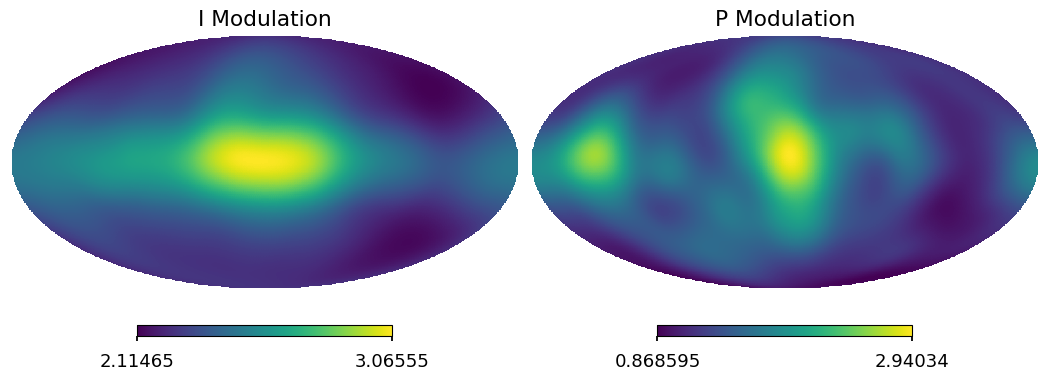

In [35]:
psm = hp.smoothing(pmod / n_eff, fwhm=np.radians(11.5))
tsm = hp.smoothing(tmod / n_eff, fwhm=np.radians(11.5))
hp.mollview(psm, sub=122, title="P Modulation")
hp.mollview(tsm, sub=121, title="I Modulation")

In [36]:
LS_lmax = 128

In [37]:
np.random.seed(777)
# filter large scales
alm_log_pol_tens_fullsky = hp.map2alm(iqu, lmax=lmax, use_pixel_weights=True)
ii_LS_alm = np.empty_like(alm_log_pol_tens_fullsky)

for ii, pol in enumerate(spectra_components[:-1]):

    sig_func = sigmoid(ell, x0=ell_fit_high[pol], width=ell_fit_high[pol] / 10)
    ii_LS_alm[ii] = hp.almxfl(alm_log_pol_tens_fullsky[ii], (1.0 - sig_func) ** 0.2)

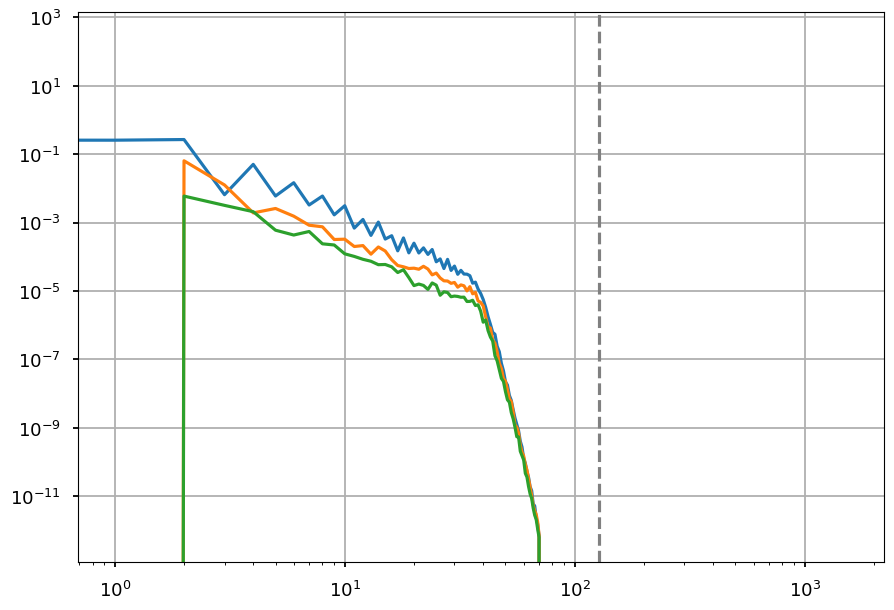

In [38]:
for pol in range(3):
    plt.loglog(hp.alm2cl(ii_LS_alm[pol]))
plt.grid()
plt.axvline(LS_lmax, color="grey", linestyle="--");

In [39]:
ii_LS_alm = hp.resize_alm(ii_LS_alm, lmax, lmax, LS_lmax, LS_lmax)

log_ss = hp.synfast(
    cl_ss,
    lmax=lmax,
    new=True,
    nside=hp.get_nside(iqu),
)
log_ss_modulated = np.zeros_like(log_ss)
log_ss_modulated[0] = log_ss[0] * (
    hp.ud_grade(tsm / tsm.max(), nside_out=hp.get_nside(log_ss))
)  # modulate_amp
log_ss_modulated[1:] = log_ss[1:] * (
    hp.ud_grade(psm, nside_out=hp.get_nside(log_ss)) - 0.5
)  # ampl_smooth_minmax

log_ls = hp.alm2map(ii_LS_alm, nside=nside)
ii_map_out = log_ss_modulated + log_ls

In [40]:
filename = proddir / f"synch_largescale_template_logpoltens_alm_lmax{LS_lmax:d}_{version}.fits"
hp.write_alm(
    filename,
    ii_LS_alm,
    lmax=LS_lmax,
    out_dtype=np.complex64,
    overwrite=True,
)
output_files.append(filename)

In [41]:
pysm.utils.add_metadata(
    [ filename ],
    coord="G",
    unit="uK_RJ",
)

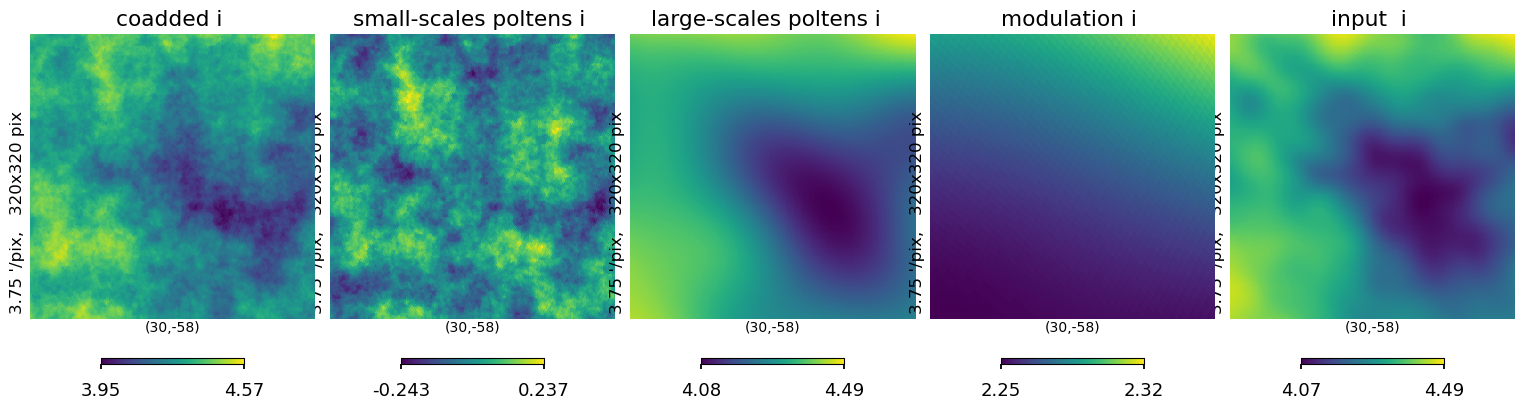

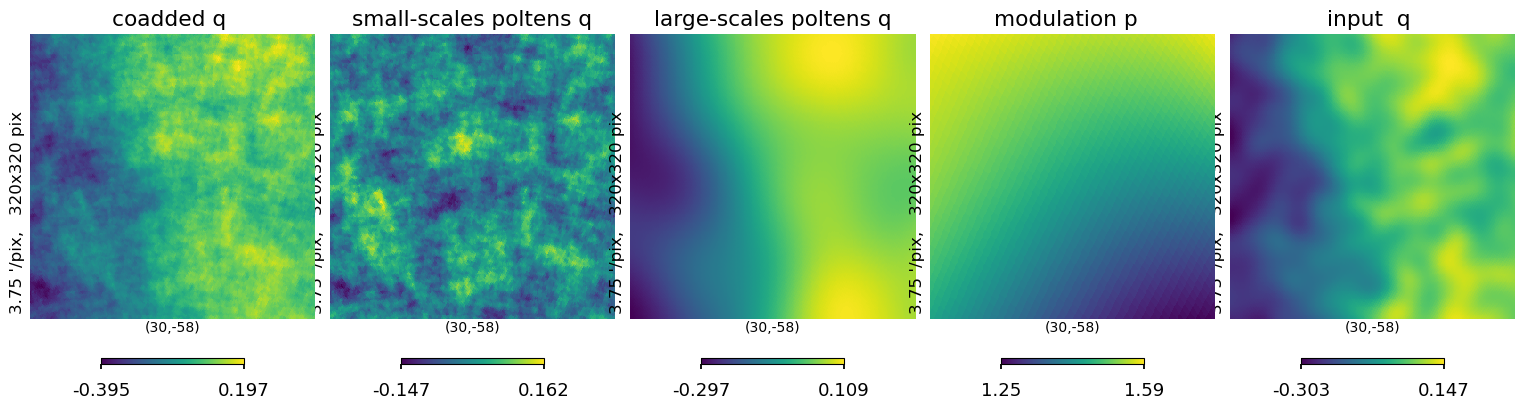

In [42]:
plt.figure(figsize=(15, 5))
hp.gnomview(
    log_ss[0],
    reso=3.75,
    xsize=320,
    rot=[30, -58],
    sub=152,
    title="small-scales poltens i ",
)
hp.gnomview(
    log_ls[0],
    reso=3.75,
    xsize=320,
    rot=[30, -58],
    sub=153,
    title="large-scales poltens i  ",
)
hp.gnomview(
    ii_map_out[0], reso=3.75, xsize=320, rot=[30, -58], sub=151, title="coadded i "
)
hp.gnomview(iqu[0], reso=3.75, xsize=320, rot=[30, -58], sub=155, title="input  i ")
hp.gnomview(tsm, reso=3.75, xsize=320, rot=[30, -58], sub=154, title="modulation i ")
# hp.gnomview(modulate_amp, reso=3.75, xsize=320, rot=[30,-58] ,sub=154,title='modulation i ' )

plt.figure(figsize=(15, 5))
hp.gnomview(
    log_ss[1],
    reso=3.75,
    xsize=320,
    rot=[30, -58],
    sub=152,
    title="small-scales poltens q",
)
hp.gnomview(
    log_ls[1],
    reso=3.75,
    xsize=320,
    rot=[30, -58],
    sub=153,
    title="large-scales poltens q",
)
hp.gnomview(
    ii_map_out[1], reso=3.75, xsize=320, rot=[30, -58], sub=151, title="coadded q "
)
hp.gnomview(iqu[1], reso=3.75, xsize=320, rot=[30, -58], sub=155, title="input  q ")
hp.gnomview(psm, reso=3.75, xsize=320, rot=[30, -58], sub=154, title="modulation p  ")
# hp.gnomview(ampl_smooth_minmax  , reso=3.75, xsize=320, rot=[30,-58] ,sub=154,title='modulation p  ' )

In [43]:
ell, cl_norm, cltot = run_anafast(ii_map_out, lmax)

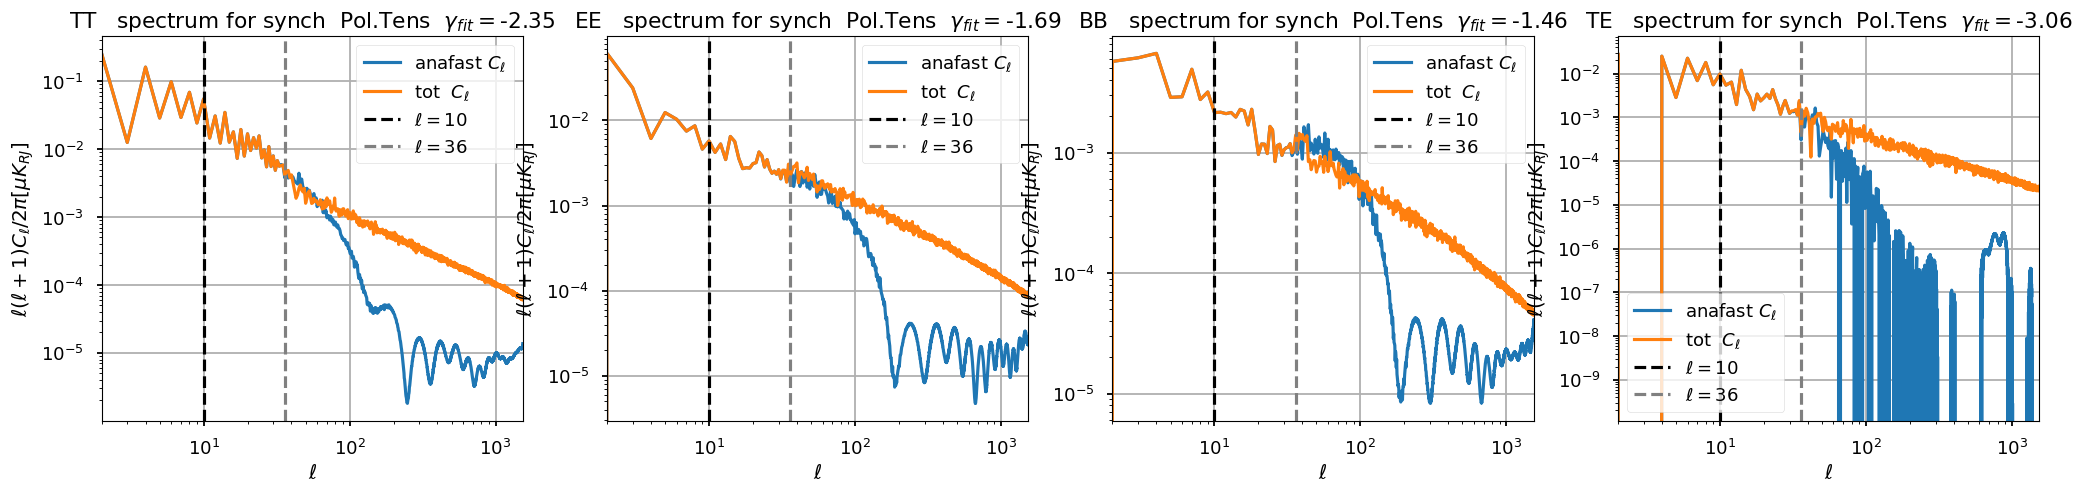

In [44]:
plt.figure(figsize=(25, 5))

for ii, pol in enumerate(spectra_components):
    plt.subplot(141 + ii)
    plt.loglog(ell, ell * (ell + 1) / np.pi / 2 * cl[pol], label="anafast $C_\ell$")
    plt.loglog(ell, ell * (ell + 1) / np.pi / 2 * cltot[pol], label="tot  $C_\ell$")

    # plt.loglog(ell, ell*(ell+1)/np.pi/2 * small_scales_input_cl[ii]  )

    plt.axvline(
        ell_fit_low[pol],
        linestyle="--",
        color="black",
        label="$ \ell={} $".format(ell_fit_low[pol]),
    )
    plt.axvline(
        ell_fit_high[pol],
        linestyle="--",
        color="gray",
        label="$ \ell={} $".format(ell_fit_high[pol]),
    )
    plt.legend()
    plt.grid()
    plt.title(
        f"{pol}   spectrum for synch  Pol.Tens  "
        + r"$\gamma_{fit}=$"
        + f"{gamma_fit[pol]:.2f}"
    )

    plt.ylabel("$\ell(\ell+1)C_\ell/2\pi [\mu K_{RJ}]$")
    plt.xlabel(("$\ell$"))
    plt.xlim(2, lmax)
    # plt.ylim(1e-5, 1e-1)

In [45]:
galplane = IQU[0].value > 200
galplane_apo = nmt.mask_apodization(galplane, 5, apotype="C2")

In [46]:
output_map = log_pol_tens_to_map(ii_map_out)
output_map = output_map * (1 - galplane_apo) + IQU.value * galplane_apo

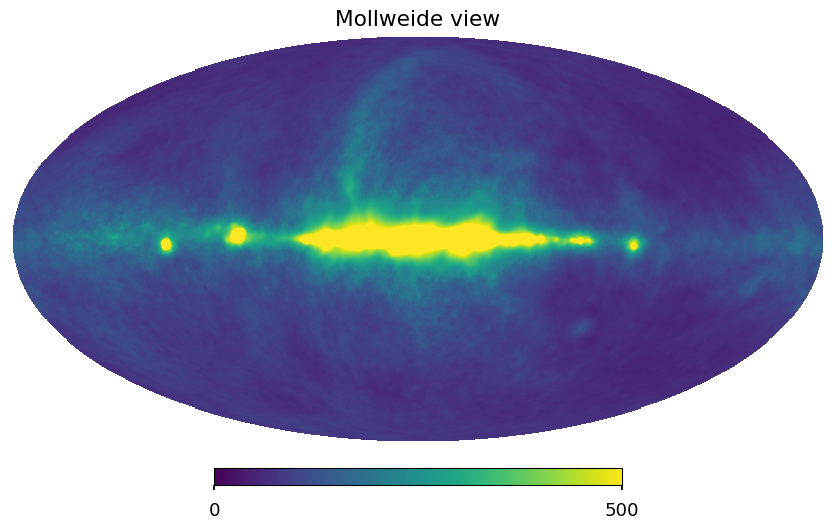

In [47]:
hp.mollview(output_map[0], min=0, max=500)

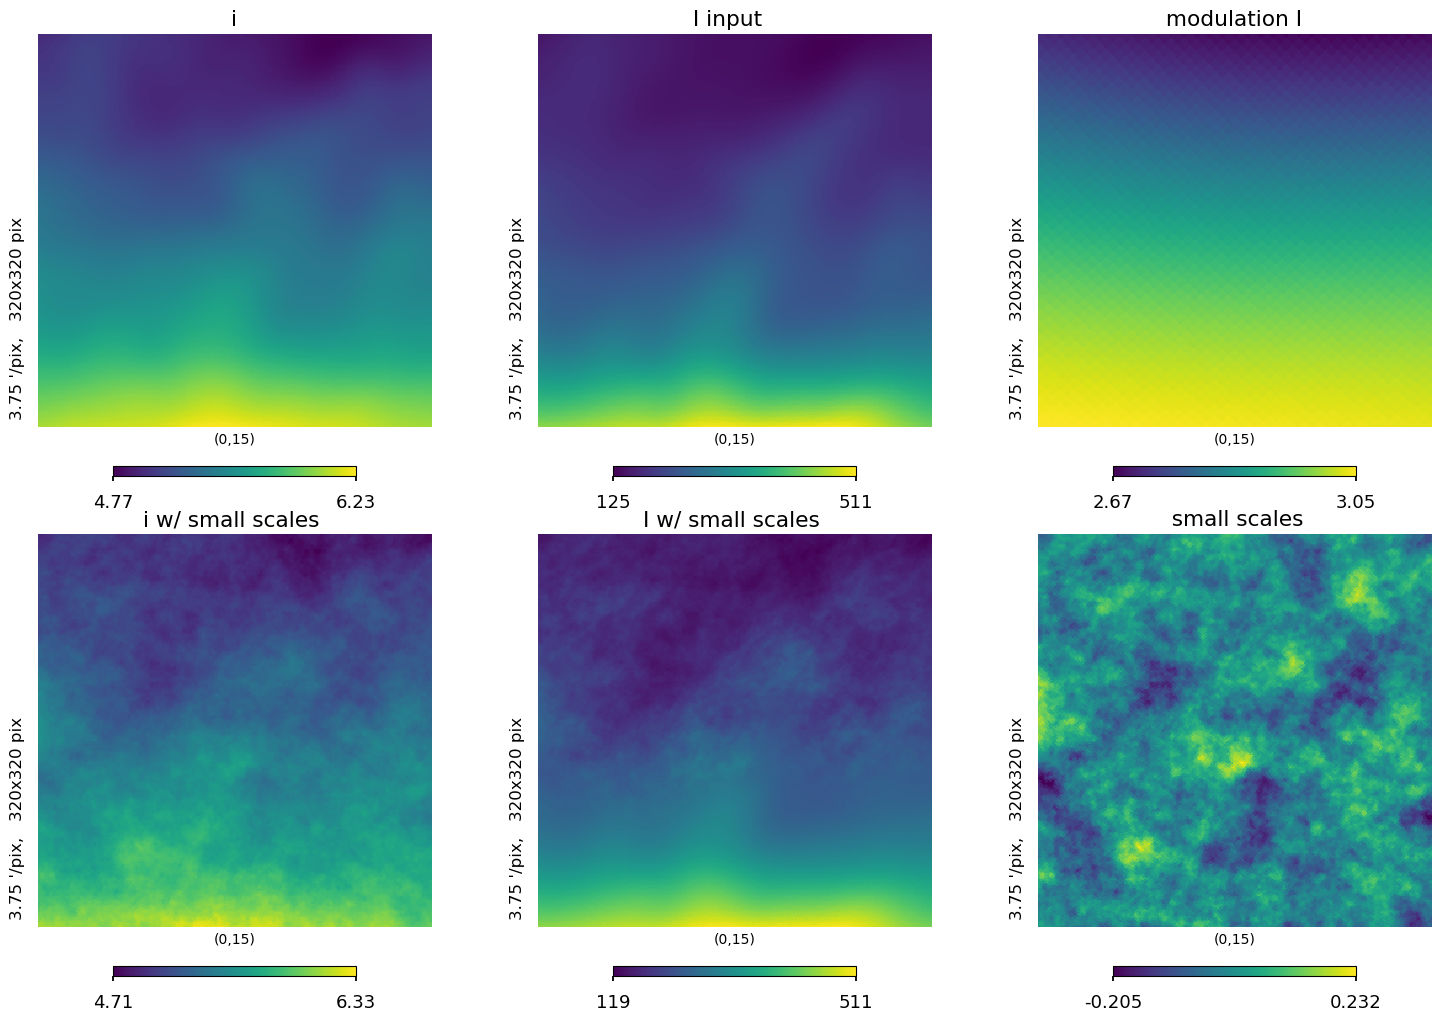

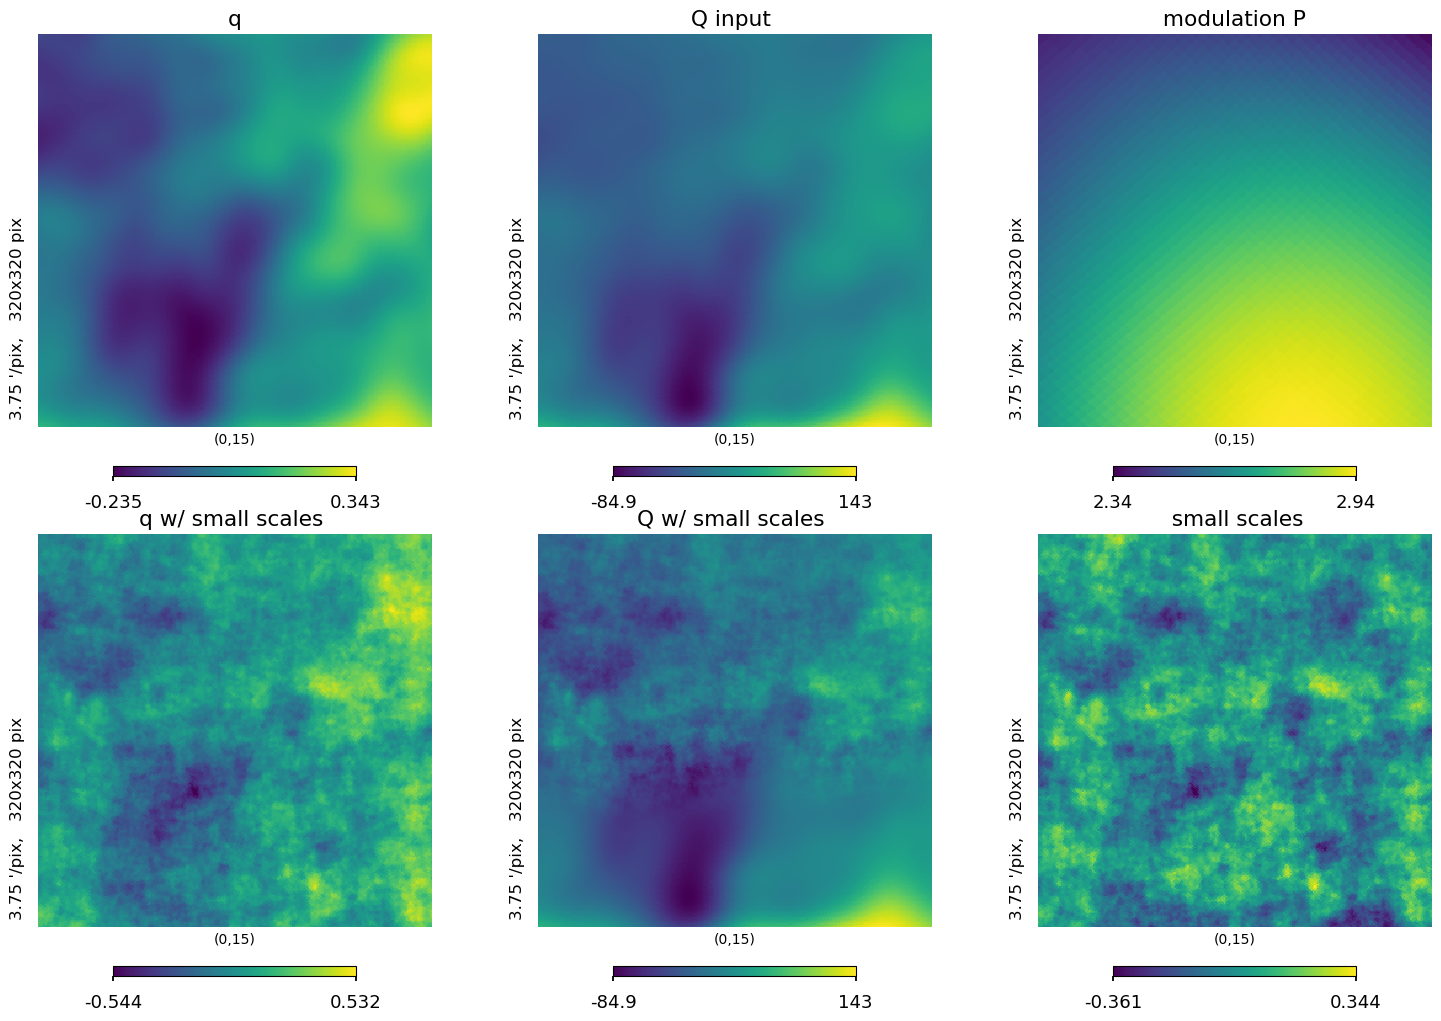

In [48]:
lat = 15
plt.figure(figsize=(15, 10))
hp.gnomview(
    ii_map_out[0],
    title="i w/ small scales ",
    rot=[0, lat],
    reso=3.75,
    xsize=320,
    sub=234,
)
hp.gnomview(iqu[0], title="i", rot=[0, lat], reso=3.75, xsize=320, sub=231)
hp.gnomview(
    tsm,
    title=" modulation I ",
    rot=[0, lat],
    reso=3.75,
    xsize=320,
    sub=233,
)

hp.gnomview(
    (IQU[0]),
    title=" I input   ",
    rot=[0, lat],
    reso=3.75,
    xsize=320,
    sub=232,
)
hp.gnomview(
    (log_ss_modulated)[0],
    title="  small scales ",
    rot=[0, lat],
    reso=3.75,
    xsize=320,
    sub=236,
)
hp.gnomview(
    output_map[0],
    title="I w/ small scales ",
    rot=[0, lat],
    reso=3.75,
    xsize=320,
    sub=235,
)
lat = 15
plt.figure(figsize=(15, 10))
hp.gnomview(
    ii_map_out[1],
    title="q w/ small scales ",
    rot=[0, lat],
    reso=3.75,
    xsize=320,
    sub=234,
)
hp.gnomview(iqu[1], title="q", rot=[0, lat], reso=3.75, xsize=320, sub=231)
hp.gnomview(
    (psm),
    title=" modulation P ",
    rot=[0, lat],
    reso=3.75,
    xsize=320,
    sub=233,
)

hp.gnomview(
    (IQU[1]),
    title=" Q input  ",
    rot=[0, lat],
    reso=3.75,
    xsize=320,
    sub=232,
)
hp.gnomview(
    (log_ss_modulated)[1],
    title="  small scales ",
    rot=[0, lat],
    reso=3.75,
    xsize=320,
    sub=236,
)
hp.gnomview(
    output_map[1],
    title="Q w/ small scales ",
    rot=[0, lat],
    reso=3.75,
    xsize=320,
    sub=235,
)

In [49]:
if not os.path.exists(datadir / "sync_pysm_mod_out_circles.fits"):
    hp.write_map(datadir / "sync_pysm_mod_out_circles.fits", output_map, overwrite=True)

### Validation 


In [50]:
bkmaskfile = datadir / "bk14_mask_gal_n0512.fits"
if not bkmaskfile.exists():
    !wget -O $bkmaskfile http://bicepkeck.org/BK14_datarelease/bk14_mask_gal_n0512.fits
maskbk = hp.read_map(bkmaskfile, verbose=False)
idx = np.where((maskbk < 0) | (~np.isfinite(maskbk)))
maskbk[idx] = 0

In [51]:
aoa = "/global/cscratch1/sd/flauger/S4_misc/weights_aoa_spsat_apo_gal_512.fits"
mask_aoa = hp.read_map(aoa, verbose=False)

In [52]:
planck_mask_filename = datadir / "HFI_Mask_GalPlane-apo2_2048_R2.00.fits"

if not planck_mask_filename.exists():
    !wget -O $planck_mask_filename "http://pla.esac.esa.int/pla/aio/product-action?MAP.MAP_ID=HFI_Mask_GalPlane-apo2_2048_R2.00.fits"

In [53]:
planck_masks = {
    "GAL099": hp.ud_grade(hp.read_map(planck_mask_filename, ["GAL099"]), nside_out=512),
    "GAL097": hp.ud_grade(hp.read_map(planck_mask_filename, ["GAL097"]), nside_out=512),
    "GAL090": hp.ud_grade(hp.read_map(planck_mask_filename, ["GAL090"]), nside_out=512),
    "GAL080": hp.ud_grade(hp.read_map(planck_mask_filename, ["GAL080"]), nside_out=512),
    "GAL070": hp.ud_grade(hp.read_map(planck_mask_filename, ["GAL070"]), nside_out=512),
    "GAL060": hp.ud_grade(hp.read_map(planck_mask_filename, ["GAL060"]), nside_out=512),
    "GAL040": hp.ud_grade(hp.read_map(planck_mask_filename, ["GAL040"]), nside_out=512),
    "GAL020": hp.ud_grade(hp.read_map(planck_mask_filename, ["GAL020"]), nside_out=512),
}

In [54]:
ell, cl_norm, clo = run_anafast(output_map, lmax=2048)
ell, cl_norm, cli = run_anafast(IQU, lmax=2048)

In [55]:
colors = plt.cm.cividis(np.linspace(0, 1, len(planck_masks.keys()) + 1))

GAL099
GAL097
GAL090
GAL080
GAL070
GAL060
GAL040
GAL020


/tmp/ipykernel_17579/791073269.py:92: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cb = plt.colorbar(sm)
/tmp/ipykernel_17579/791073269.py:109: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cb = plt.colorbar(sm)


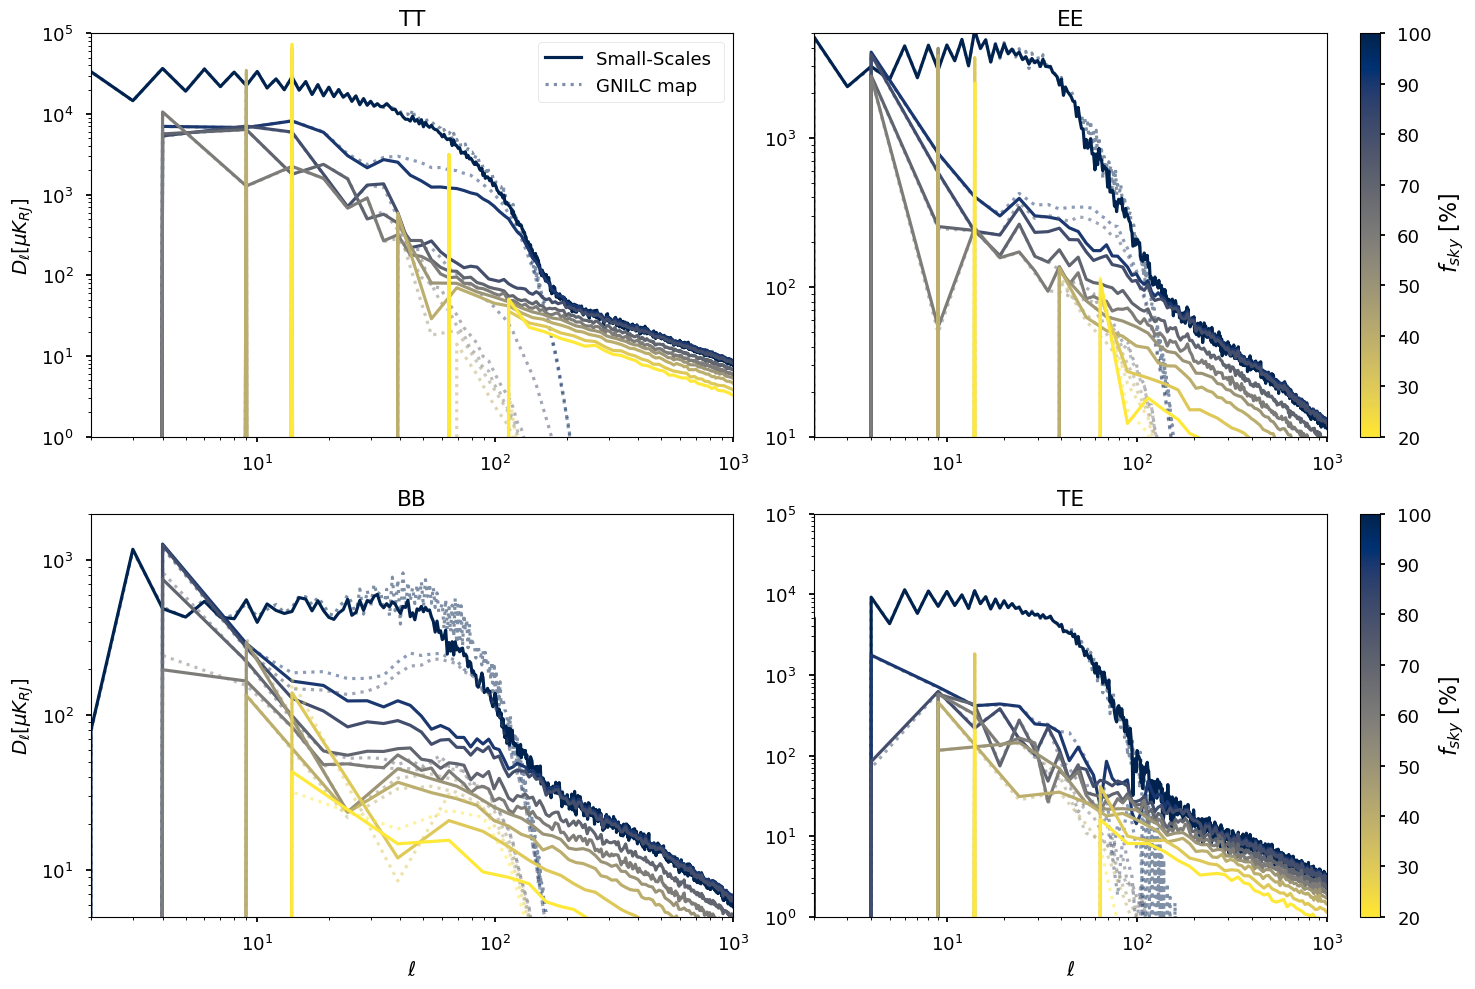

In [56]:
bins = {
    "GAL099": 5,
    "GAL097": 5,
    "GAL090": 5,
    "GAL080": 5,
    "GAL070": 15,
    "GAL060": 15,
    "GAL040": 25,
    "GAL020": 25,
}
plt.figure(figsize=(15, 10))
import os

# for jj, k in enumerate([ "GAL080","GAL040","GAL020" ])  :
for jj, k in enumerate(planck_masks.keys()):
    print(k)
    fspectra = datadir / f"sync_input_gal{k[3:]}_spectra.npz"
    if os.path.exists(fspectra):
        input_ell = np.load(fspectra)["ell"]
        cl_in = {kk: np.load(fspectra)[kk] for kk in spectra_components + ["TE"]}
    else:
        input_ell, cl_norm, cl_in = run_namaster(
            m=IQU, mask=planck_masks[k], lmax=1300, nlbins=bins[k]
        )
        np.savez(
            fspectra,
            ell=input_ell,
            TT=cl_in["TT"],
            EE=cl_in["EE"],
            BB=cl_in["BB"],
            TE=cl_in["TE"],
        )
    fspectra = datadir / f"sync_galplane_gal{k[3:]}_spectra.npz"

    if os.path.exists(fspectra):
        output_ell = np.load(fspectra)["ell"]
        cl_out = {kk: np.load(fspectra)[kk] for kk in spectra_components + ["TE"]}
    else:

        output_ell, cl_norm, cl_out = run_namaster(
            m=output_map, mask=planck_masks[k], lmax=1300, nlbins=bins[k]
        )
        np.savez(
            fspectra,
            ell=output_ell,
            TT=cl_out["TT"],
            EE=cl_out["EE"],
            BB=cl_out["BB"],
            TE=cl_out["TE"],
        )

    for ii, pol in enumerate(["TT", "EE", "BB", "TE"]):
        plt.subplot(2, 2, ii + 1)
        if jj == 0:
            plt.title(pol)
            plt.loglog(
                ell,
                ell**2 * (clo[pol]),
                label="Small-Scales ",
                color=colors[0],
            )
            plt.loglog(
                ell,
                ell**2 * (cli[pol]),
                ":",
                label="GNILC map ",
                color=colors[0],
                alpha=0.5,
            )
        plt.loglog(output_ell, output_ell**2 * (cl_out[pol]), color=colors[jj + 1])
        # ,label =f"{k}")
        plt.loglog(
            input_ell,
            input_ell**2 * (cl_in[pol]),
            ":",
            color=colors[jj + 1],
            alpha=0.5,
        )

plt.subplot(221)
plt.legend()
plt.ylabel("$ D_\ell  [\mu K_{RJ}]$")
plt.ylim(1e0, 1e5)
plt.xlim(2, 1e3)

plt.subplot(222)
plt.ylim(1e1, 5e3)
plt.xlim(2, 1e3)
sm = plt.cm.ScalarMappable(
    cmap=plt.cm.cividis_r, norm=plt.Normalize(vmin=20.0, vmax=100)
)
cb = plt.colorbar(sm)
cb.set_label(r" $f_{sky}$ [%]", rotation=90, fontsize=16)
plt.subplot(223)
plt.ylabel("$ D_\ell  [\mu K_{RJ}]$")
plt.xlabel(("$\ell$"))

plt.ylim(5e0, 2e3)
plt.xlim(2, 1e3)

plt.subplot(224)
plt.ylim(1e0, 1e5)
plt.xlim(2, 1e3)

plt.xlabel(("$\ell$"))
sm = plt.cm.ScalarMappable(
    cmap=plt.cm.cividis_r, norm=plt.Normalize(vmin=20.0, vmax=100)
)
cb = plt.colorbar(sm)
cb.set_label(r"$f_{sky}$ [%]", rotation=90, fontsize=16)
plt.tight_layout()

/tmp/ipykernel_17579/972234778.py:13: RuntimeWarning: invalid value encountered in divide
  plt.plot(ell, (clo["EE"] / clo["BB"]), color=colors[0], alpha=1)
/tmp/ipykernel_17579/972234778.py:14: RuntimeWarning: invalid value encountered in divide
  plt.plot(output_ell, (cl_out["EE"] / cl_out["BB"]), color=colors[jj + 1], alpha=1)
/tmp/ipykernel_17579/972234778.py:21: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cb = plt.colorbar(sm)


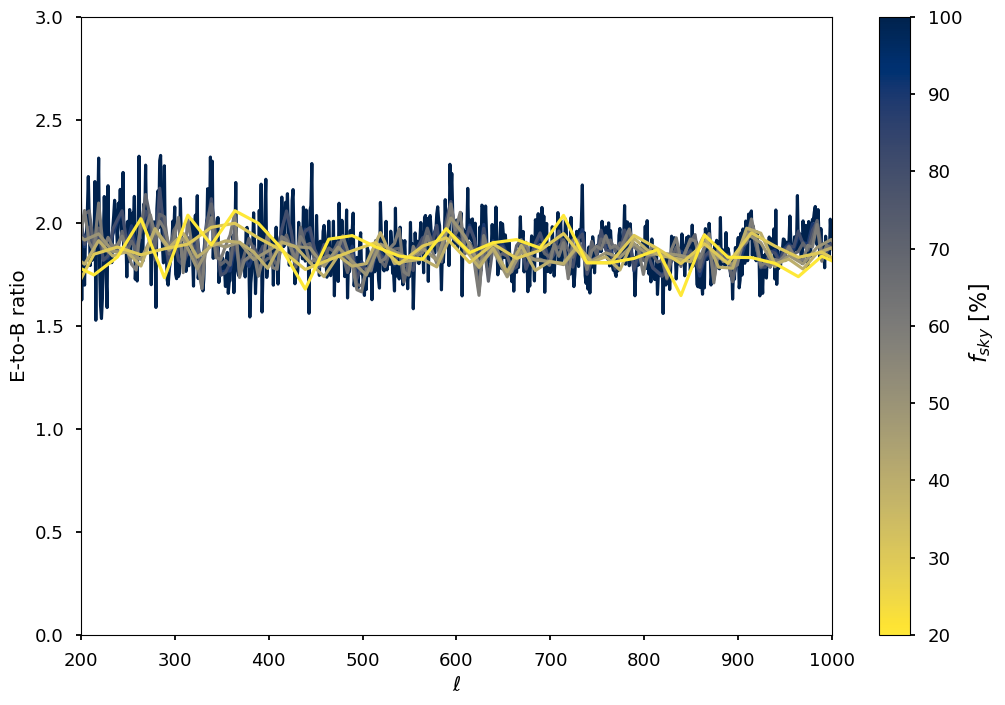

In [57]:
# plt.figure(figsize=(15,10 ))
import os

for jj, k in enumerate(planck_masks.keys()):

    fspectra = datadir / f"sync_galplane_gal{k[3:]}_spectra.npz"
    if os.path.exists(fspectra):
        #        print("read Namaster spectra  ")
        output_ell = np.load(fspectra)["ell"]
        cl_out = {kk: np.load(fspectra)[kk] for kk in spectra_components + ["TE"]}

    if jj == 0:
        plt.plot(ell, (clo["EE"] / clo["BB"]), color=colors[0], alpha=1)
    plt.plot(output_ell, (cl_out["EE"] / cl_out["BB"]), color=colors[jj + 1], alpha=1)

plt.xlim(200, 1e3)
plt.ylim(0, 3)
sm = plt.cm.ScalarMappable(
    cmap=plt.cm.cividis_r, norm=plt.Normalize(vmin=20.0, vmax=100)
)
cb = plt.colorbar(sm)
cb.set_label(r" $f_{sky}$ [%]", rotation=90, fontsize=16)
plt.xlabel(("$\ell$"))
plt.ylabel(("E-to-B ratio"))

plt.tight_layout()

In [58]:
def ClBB(mask, mapp):
    map1 = mapp.copy()
    b = nmt.NmtBin.from_nside_linear(hp.get_nside(mask), 40)
    f_2 = nmt.NmtField(mask, map1, purify_b=True)
    cl_22 = nmt.compute_full_master(f_2, f_2, b)
    ell_arr = b.get_effective_ells()
    return (ell_arr, cl_22[3], cl_22[0])

In [59]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc

In [60]:
i_dic = {}
(ells, clBB_i, clEE_i) = ClBB(mask_aoa, IQU[1:, :])

i_dic["S4"] = [clBB_i, clEE_i]
(ells, clBB_i, clEE_i) = ClBB(maskbk, IQU[1:, :])
i_dic["BK"] = [clBB_i, clEE_i]

In [61]:
o_dic = {}

(oells, clBB_o, clEE_o) = ClBB(mask_aoa, output_map[1:, :])
o_dic["S4"] = [clBB_o, clEE_o]
(oells, clBB_o, clEE_o) = ClBB(maskbk, output_map[1:, :])
o_dic["BK"] = [clBB_o, clEE_o]

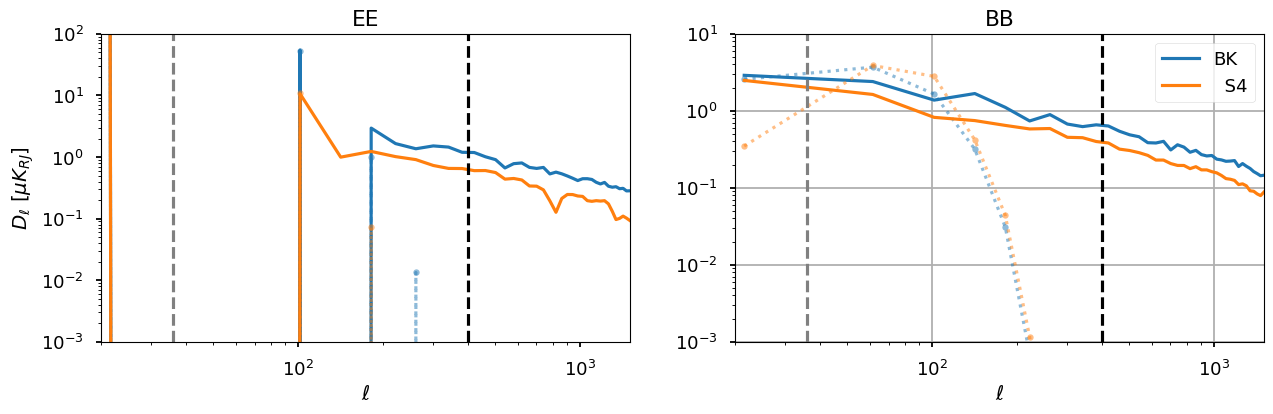

In [62]:
plt.figure(figsize=(15, 4))
plt.subplot(121)
plt.title("EE")
plt.ylabel("$ D_\ell\,\,  [\mu K_{RJ}]$")
plt.xlabel(("$\ell$"))

plt.plot(
    ells,
    ells * (ells + 1.0) * i_dic["BK"][1] / (2.0 * np.pi),
    ".",
    alpha=0.5,
    color="C0",
    linestyle=":",
)
plt.plot(
    oells,
    oells * (oells + 1.0) * o_dic["BK"][1] / (2.0 * np.pi),
    label="BK",
    color="C0",
)
plt.plot(
    ells,
    ells * (ells + 1.0) * i_dic["S4"][1] / (2.0 * np.pi),
    ".",
    alpha=0.5,
    color="C1",
    linestyle=":",
)
plt.plot(
    oells,
    oells * (oells + 1.0) * o_dic["S4"][1] / (2.0 * np.pi),
    label="Southern-Hole",
    color="C1",
)
plt.loglog()
plt.ylim(1e-3, 1e2)
plt.xlim(20, 1.5e3)
plt.axvline(ell_fit_high[pol], linestyle="--", color="gray")
plt.axvline(ell_pivot, linestyle="--", color="k")
plt.subplot(122)
plt.title("BB")
plt.xlabel(("$\ell$"))
plt.plot(
    ells,
    ells * (ells + 1.0) * i_dic["BK"][0] / (2.0 * np.pi),
    ".",
    alpha=0.5,
    color="C0",
    linestyle=":",
)
plt.plot(
    oells,
    oells * (oells + 1.0) * o_dic["BK"][0] / (2.0 * np.pi),
    label="BK",
    color="C0",
)
plt.plot(
    ells,
    ells * (ells + 1.0) * i_dic["S4"][0] / (2.0 * np.pi),
    ".",
    alpha=0.5,
    color="C1",
    linestyle=":",
)
plt.plot(
    oells,
    oells * (oells + 1.0) * o_dic["S4"][0] / (2.0 * np.pi),
    label="  S4",
    color="C1",
)
plt.loglog()
plt.ylim(1e-3, 1e1)
plt.xlim(20, 1.5e3)
plt.axvline(ell_fit_high[pol], linestyle="--", color="gray")
plt.axvline(ell_pivot, linestyle="--", color="k")
plt.legend()
plt.grid()

In [63]:
get_polfrac = lambda m: np.sqrt(m[1] ** 2 + m[2] ** 2) / m[0]

In [64]:
Pout = get_polfrac(output_map)
Pin = get_polfrac(IQU.value)
logpin = np.log10(Pin)
logpout = np.log10(Pout)

In [65]:
planck_masks_bool = {
    k: np.ma.masked_greater(m, 0).mask for k, m in planck_masks.items()
}

GAL099
GAL097
GAL090
GAL080
GAL070
GAL060
GAL040
GAL020


(-2.0, 0.0)

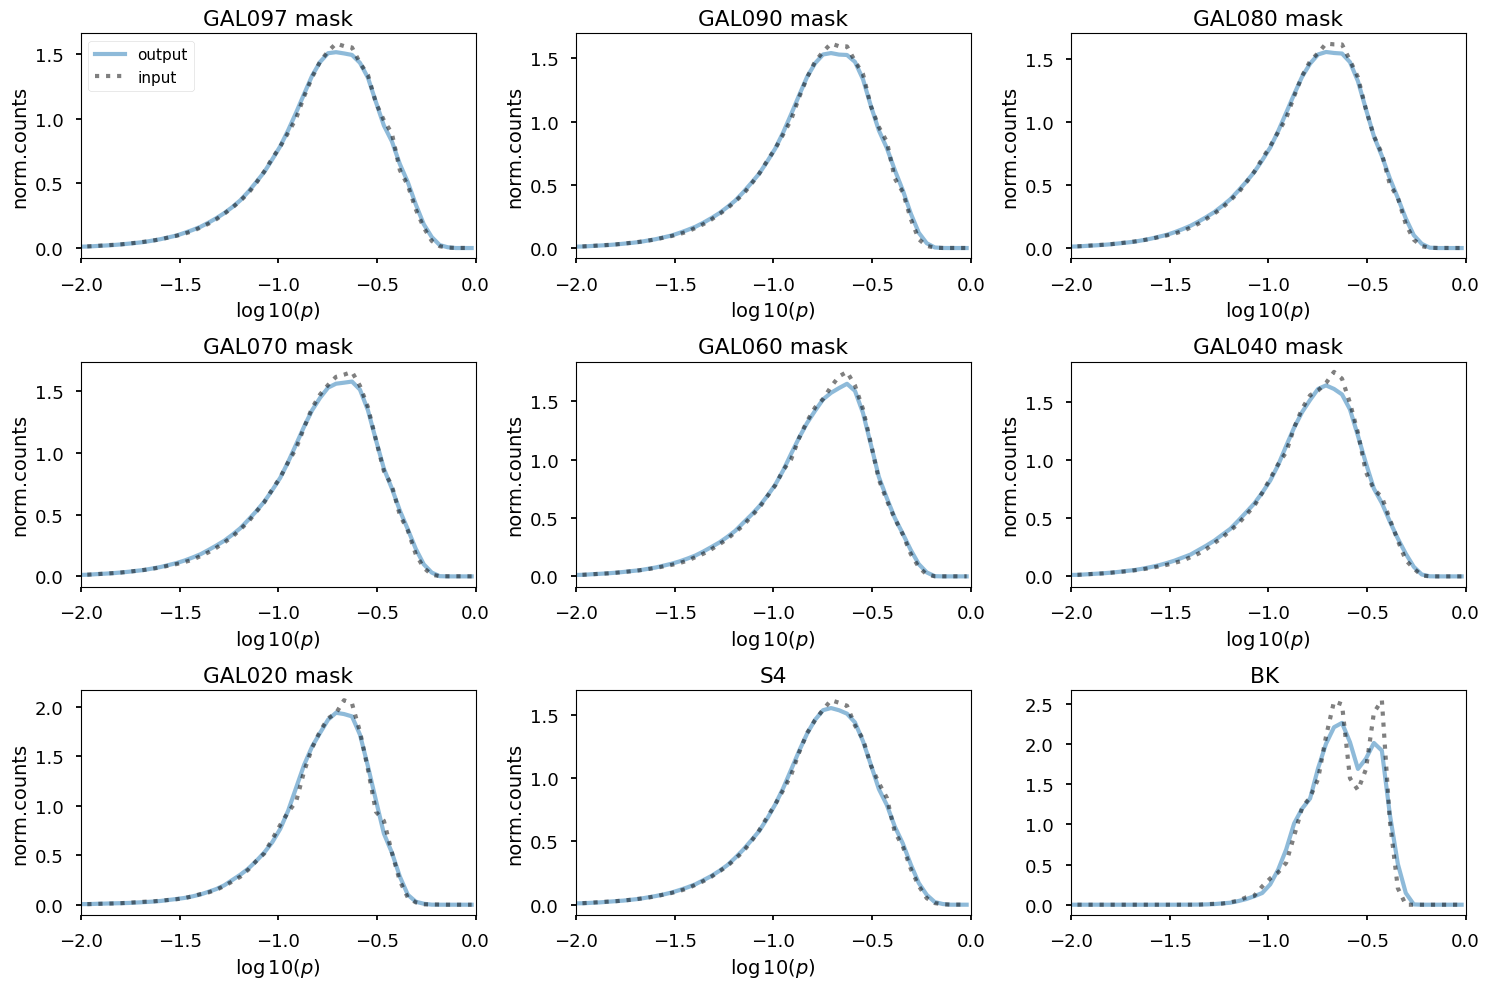

In [66]:
plt.figure(figsize=(15, 10))

for jj, pm in enumerate(planck_masks_bool.items()):
    k = pm[0]
    msk = pm[1]
    print(k)
    if k == "GAL099":
        continue
    plt.subplot(3, 3, jj)

    h, edg = np.histogram(logpout[msk], bins=np.linspace(-4, 0, 100), density=True)
    xb = np.array([(edg[i] + edg[i + 1]) / 2 for i in range(edg.size - 1)])

    plt.plot(xb, h, lw=3, color="C0", alpha=0.5, label="output")
    h, edg = np.histogram(logpin[msk], density=True, bins=np.linspace(-4, 0, 100))
    xb = np.array([(edg[i] + edg[i + 1]) / 2 for i in range(edg.size - 1)])

    plt.plot(xb, h, lw=3, alpha=0.5, color="k", linestyle=":", label="input")
    plt.ylabel("norm.counts", fontsize=14)
    plt.xlabel(r"$\log10( p )$", fontsize=14)
    plt.title(k + " mask")
    plt.xlim(-2, -0)

plt.tight_layout()
plt.subplot(331)
plt.legend(fontsize=11, loc="upper left")

plt.subplot(339)


h, edg = np.histogram(
    logpout[np.ma.masked_greater(maskbk, 0).mask],
    bins=np.linspace(-4, 0, 100),
    density=True,
)
xb = np.array([(edg[i] + edg[i + 1]) / 2 for i in range(edg.size - 1)])
plt.plot(xb, h, lw=3, color="C0", alpha=0.5, label="output")
h, edg = np.histogram(
    logpin[np.ma.masked_greater(maskbk, 0).mask],
    density=True,
    bins=np.linspace(-4, 0, 100),
)
xb = np.array([(edg[i] + edg[i + 1]) / 2 for i in range(edg.size - 1)])
plt.plot(xb, h, lw=3, alpha=0.5, color="k", linestyle=":", label="input")
plt.title("BK ")
plt.xlim(-2, -0)

plt.subplot(338)


h, edg = np.histogram(
    logpout[np.ma.masked_greater(mask_aoa, 0).mask],
    bins=np.linspace(-4, 0, 100),
    density=True,
)
xb = np.array([(edg[i] + edg[i + 1]) / 2 for i in range(edg.size - 1)])
plt.plot(xb, h, lw=3, color="C0", alpha=0.5, label="output")
h, edg = np.histogram(
    logpin[np.ma.masked_greater(mask_aoa, 0).mask],
    density=True,
    bins=np.linspace(-4, 0, 100),
)
xb = np.array([(edg[i] + edg[i + 1]) / 2 for i in range(edg.size - 1)])
plt.plot(xb, h, lw=3, alpha=0.5, color="k", linestyle=":", label="input")
plt.ylabel("norm.counts", fontsize=14)
plt.xlabel(r"$\log10( p )$", fontsize=14)
plt.title("S4")
plt.xlim(-2, -0)

## Save spectra to higher ell

In [67]:
output_nside = 8192
output_lmax = 2 * output_nside
lmax = output_lmax
ell = np.arange(output_lmax + 1)
cl_norm = ell * (ell + 1) / np.pi / 2
cl_norm[:1] = 1

In [68]:
output_ell = np.arange(output_lmax + 1, dtype=np.float64)[len(smallscales[0]) :]
output_cl_norm = output_ell * (output_ell + 1) / np.pi / 2

In [69]:
for ii, pol in enumerate(spectra_components):
    if pol == "TE":
        scaling = model(output_ell, A_fit2[pol], gamma_fit2["TE"])
        smallscales[ii] = np.concatenate([smallscales[ii], scaling])
    else:
        scaling = model(output_ell, A_fit2[pol], gamma_fit2["TT"])
        smallscales[ii] = np.concatenate([smallscales[ii], scaling])

In [70]:
output_ell = np.arange(output_lmax + 1)
output_cl_norm = output_ell * (output_ell + 1) / np.pi / 2
output_cl_norm[:1] = 1

In [71]:
len(smallscales[0]), len(output_cl_norm)

(16385, 16385)

In [72]:
cl_ss = [
    smallscales[ii]
    * sigmoid(output_ell, ell_fit_high[pol], ell_fit_high[pol] / 10)
    / output_cl_norm
    for ii, pol in enumerate(spectra_components)
]

In [73]:
filename = proddir / f"synch_small_scales_cl_lmax{output_lmax}_{version}.fits"
hp.write_cl(
    filename,
    cl_ss,
    dtype=np.complex128,
    overwrite=True,
)

In [74]:
pysm.utils.add_metadata(
    [filename],
    coord="G",
    unit="uK_RJ**2",
)

In [75]:
output_files.append(filename)

In [76]:
mod_lmax = 64

In [77]:
tsm /= tsm.max()
psm -= 0.5

for name, each_modulate in [("temperature", tsm), ("polarization", psm)]:
    filename = proddir / f"synch_{name}_modulation_alms_lmax{int(mod_lmax):d}_{version}.fits"
    alm = hp.map2alm(each_modulate, lmax=mod_lmax, use_pixel_weights=True)
    hp.write_alm(
        filename,
        alm,
        overwrite=True,
        out_dtype=np.float32,
    )
    pysm.utils.add_metadata(
        [filename],
        coord="G",
        unit="",
    )
    output_files.append(filename)

In [78]:
mod_cl_t = hp.anafast(tsm)
mod_cl_p = hp.anafast(psm)

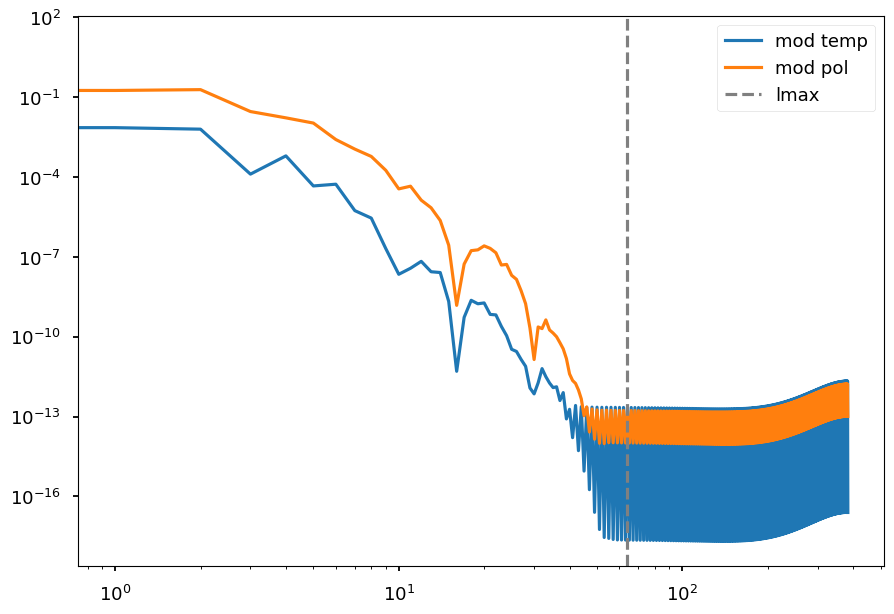

In [79]:
plt.loglog(mod_cl_t, label="mod temp")
plt.loglog(mod_cl_p, label="mod pol")
plt.axvline(mod_lmax, color="grey", linestyle="--", label="lmax")
plt.legend();

In [80]:
for fitsfile in output_files:
    !gzip -f $fitsfile